## Описание признаков dataset:

client_id - идентификатор клиента  
app_date - дата подачи заявки  
education - уровень образования 
sex - пол заемщика  
age - возраст заемщика  
car - флаг наличия автомобиля  
car_type - флаг автомобиля иномарки  
decline_app_cnt - количество отказанных прошлых заявок  
good_work - флаг наличия “хорошей” работы  
score_bki - скоринговый балл по данным из БКИ  
bki_request_cnt - количество запросов в БКИ  
region_rating - рейтинг региона  
home_address - категоризатор домашнего адреса  
work_address - категоризатор рабочего адреса  
income - доход заемщика  
sna - связь заемщика с клиентами банка  
first_time - давность наличия информации о заемщике  
foreign_passport - наличие загранпаспорта  
test_df - флаг принадлежности данных к тестовому датасету  
default - флаг дефолта по кредиту  

In [1354]:
# импортируем необхоимые библиотеки
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [1355]:
# произведем настройки отображения всех столбцов
import os
pd.set_option('display.max_columns', 50)

# настраиваем получение информации в kaggle
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## ЗАГРУЗКА ДАННЫХ

In [1356]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

## ПЕРВОНАЧАЛЬНЫЙ ОСМОТР ИСХОДНЫХ ДАННЫХ

In [1357]:
# информация по тренировочному датасету
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [1358]:
print('Всего пропусков:')
train.isnull().sum()

Всего пропусков:


client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [1359]:
print(
    f'В тренировочном датасете train {train.shape[0]} строк и {train.shape[1]} признаков.')
display(train.sample(10))

В тренировочном датасете train 73799 строк и 19 признаков.


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
38662,64066,13MAR2014,UGR,M,28,N,N,0,0,-2.630700,1,60,2,3,48000,1,1,N,0
6511,29126,05FEB2014,GRD,M,54,Y,Y,0,0,-2.970004,0,70,2,3,45000,1,3,N,0
2355,67233,16MAR2014,SCH,F,24,N,N,0,1,-2.104211,0,50,1,1,30000,1,3,N,0
43826,18232,25JAN2014,SCH,M,33,N,N,0,0,-1.583149,1,50,2,3,21000,1,3,N,1
33477,2943,09JAN2014,SCH,M,27,N,N,0,0,-1.847767,7,50,2,3,40000,1,4,N,1
17792,67948,17MAR2014,GRD,F,43,N,N,0,0,-1.621282,1,60,2,3,70000,4,1,N,0
54950,1239,05JAN2014,UGR,M,48,N,N,0,0,-1.651710,3,80,2,3,90000,4,3,N,0
35173,6402,13JAN2014,SCH,M,47,Y,Y,0,0,-1.598298,0,50,2,2,80000,1,4,N,0
42850,43907,20FEB2014,SCH,M,38,Y,N,0,0,-2.704357,3,50,1,2,40000,1,3,N,0
51414,88932,05APR2014,GRD,M,37,Y,Y,1,0,-1.340576,0,60,2,3,50000,1,2,N,1


Text(0.5, 1.0, 'Диаграма целевого признака default в тренировочном датасете, %')

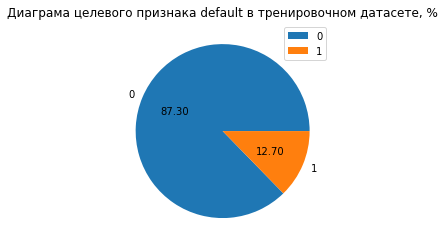

In [1360]:
# распределение целевого признака default на тренировочном датасете
train['default'].value_counts().plot(
    kind='pie', label='', normalize=True, autopct="%.2f")
plt.legend()
plt.title('Диаграма целевого признака default в тренировочном датасете, %')

In [1361]:
# рассмотрим тестовый датасет
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [1362]:
print('Всего пропусков:')
test.isnull().sum()

Всего пропусков:


client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

In [1363]:
print(
    f'В тестовом датасете test {test.shape[0]} строк и {test.shape[1]} признаков.')
display(test.sample(10))

В тестовом датасете test 36349 строк и 18 признаков.


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
18128,16131,23JAN2014,SCH,F,30,N,N,0,0,-1.980809,1,80,2,3,23000,1,3,N
3344,68391,17MAR2014,SCH,M,31,Y,N,0,0,-2.160691,0,60,2,3,30000,1,2,N
31788,80596,28MAR2014,PGR,F,70,N,N,0,0,-2.447239,3,40,2,3,17250,1,4,N
11355,88980,05APR2014,PGR,M,52,Y,Y,0,0,-1.768836,1,80,2,3,200000,1,3,N
27061,67044,16MAR2014,UGR,M,21,N,N,1,0,-1.478411,2,50,1,2,50000,2,3,Y
26531,72031,19MAR2014,GRD,M,53,Y,N,0,0,-1.934797,1,80,2,3,34000,1,3,N
14833,105901,24APR2014,SCH,F,37,N,N,1,0,-1.025861,2,50,2,3,45000,4,1,N
1095,58072,06MAR2014,GRD,M,31,Y,Y,0,1,-1.379694,3,50,1,2,45000,1,3,N
21420,98892,15APR2014,GRD,F,43,N,N,1,0,-2.780825,1,60,2,3,20000,1,2,N
13888,70769,19MAR2014,SCH,F,54,Y,N,0,0,-2.438435,9,60,1,2,95000,1,3,N


В тестовом датасете на 1 признак меньше - это целевая переменная default, структура данных сохранена, пропуски есть в поле education.

## ОБРАБОТКА ДАННЫХ

In [1364]:
# объединим датасеты в один общий.
# для этого введем признак принадлежности к тестовому датасету test_df
test['test_df'] = 1
train['test_df'] = 0
# в тестовый датасет введем признак defualt, заполним его 0
test['default'] = 0
# объединим обновленные датасеты
data = test.append(train).reset_index(drop=True)

In [1365]:
display(data)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,test_df,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,1,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,1,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,1,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,1,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0,0
110144,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0,0
110145,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0,0
110146,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,0,1


In [1366]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

None

В итоговом датасете 20 признаков, 14 из которых определены как числовые, а 6 - как строковые. Целевым признаком является default - он является бинарным и должен принимать только значения 0 или 1. Признак test_df является вспомогательным и служит для выделения в общем датасете тестового.

In [1367]:
# проверим, что признаки sex, сar, car_type, good_work, foreign_passport являются бинарными
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
for col in bin_cols:
    print(f'Признак {col} принимает следующие значния:')
    display(data[col].value_counts())

Признак sex принимает следующие значния:


F    61836
M    48312
Name: sex, dtype: int64

Признак car принимает следующие значния:


N    74290
Y    35858
Name: car, dtype: int64

Признак car_type принимает следующие значния:


N    89140
Y    21008
Name: car_type, dtype: int64

Признак good_work принимает следующие значния:


0    91917
1    18231
Name: good_work, dtype: int64

Признак foreign_passport принимает следующие значния:


N    93721
Y    16427
Name: foreign_passport, dtype: int64

In [1368]:
# преобразуем символьные бинарные признаки в числовые
bin_cols.remove('good_work')
label_encoder = LabelEncoder()
for col in bin_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [1369]:
display(data)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,test_df,default
0,74835,22MAR2014,GRD,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,1,0
1,17527,24JAN2014,SCH,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,1,0
2,75683,23MAR2014,UGR,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,1,0
3,26883,03FEB2014,SCH,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,1,0
4,28862,04FEB2014,GRD,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,GRD,0,45,0,0,0,0,-1.792064,3,50,1,2,17000,4,4,0,0,0
110144,76821,24MAR2014,SCH,1,41,1,1,0,0,-2.058029,1,50,2,2,70000,1,4,0,0,0
110145,103695,22APR2014,SCH,1,31,0,0,0,0,-1.512635,4,80,2,3,45000,2,2,0,0,0
110146,861,04JAN2014,SCH,0,29,0,0,0,1,-1.479334,3,50,1,3,13000,2,3,0,0,1


SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

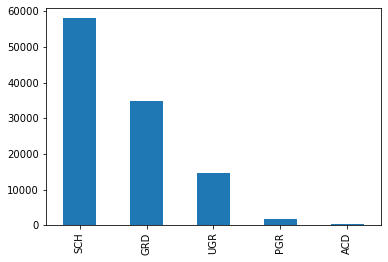

In [1370]:
# рассмотрим признак education
display(data.education.value_counts())
data.education.value_counts().plot(kind="bar")
plt.show()

In [1371]:
# заполним пропуски в признаке education в зависимости от возраста, пола и наличия машины у человека
# для этого создадим урезанный датасет из нужных признаков, чтобы упросить его обработку
df_dict = data[['education', 'sex', 'age', 'car']]

# создадим словарь, в котором ключу (возраст, пол, признак машины) будет соответствовать максимально встречающееся для такого набора параметров
# значение образования,
# если в заполненных данных какой-то ключ из всех возможных не встречается, то значение равно наиболее встречаемому типу обучения по всему
# датасету - 'SCH'
education_dict = {}
ages = set(df_dict.age)
for age_ in ages:
    for sex_ in range(2):
        for car_ in range(2):
            dff = df_dict.loc[(df_dict.age == age_) & (df_dict.sex == sex_)
                              & (df_dict.car == car_), 'education']
            if dff.value_counts().empty:
                education_dict[(age_, sex_, car_)] = 'SCH'
                break
            education_dict[(age_, sex_, car_)] = dff.value_counts().index[0]

In [1372]:
# определим индексы строк, с пропущенными данными в признаке education
education_empty = list(data[data.education.isnull()].index)

# заполним пропуски по словарю
for ind in education_empty:
    data.loc[ind, 'education'] = education_dict[(
        data.loc[ind, 'age']), (data.loc[ind, 'sex']), (data.loc[ind, 'car'])]

In [1373]:
# проверим все ли пропуски в датасете убраны
display(data.isnull().sum())

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
test_df             0
default             0
dtype: int64

In [1374]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         110148 non-null  object 
 3   sex               110148 non-null  int64  
 4   age               110148 non-null  int64  
 5   car               110148 non-null  int64  
 6   car_type          110148 non-null  int64  
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

None

In [1375]:
# для удобства обработки выделим признак app_date в отдельный датасет
df_date = pd.DataFrame(data['app_date'])
# преобразуем данные признака app_date в формат datetime
df_date['app_date'] = pd.to_datetime(
    df_date['app_date'], format="%d%b%Y", errors='ignore')

In [1376]:
# выделим день, месяц, год, день недели в отдельные признаки app_d, app_m, app_y, app_wd соответственно
df_date['app_d'] = df_date['app_date'].dt.day
df_date['app_m'] = df_date['app_date'].dt.month
df_date['app_y'] = df_date['app_date'].dt.year
df_date['app_wd'] = df_date['app_date'].dt.weekday

In [1377]:
# рассмотрим варианты значения признака app_y
df_date.app_y.value_counts()

2014    110148
Name: app_y, dtype: int64

In [1378]:
# так как значение этого признака во всех строках одинаковое, то оно не имеет значения и его можно удалить
df_date.drop(['app_y'], axis=1, inplace=True)
# удалим также и исходный признак app_date
df_date.drop(['app_date'], axis=1, inplace=True)

In [1379]:
# добавим полученные данные в исходный датасет
data = pd.concat([data, df_date], axis=1)

In [1380]:
# удалим признак app_date из исходного датасета
data.drop(['app_date'], axis=1, inplace=True)

In [1381]:
display(data.sample(10))

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,test_df,default,app_d,app_m,app_wd
85128,4154,SCH,1,23,0,0,2,0,-1.824721,3,70,2,3,35000,4,1,0,0,0,10,1,4
17936,18521,SCH,0,38,0,0,0,0,-1.411709,2,60,2,3,15000,4,3,0,1,0,26,1,6
27036,59104,SCH,1,33,0,0,0,0,-1.558255,3,50,2,3,20000,2,3,0,1,0,7,3,4
37078,16568,GRD,1,44,0,0,0,0,-2.588108,0,80,2,3,5000,1,3,0,0,0,23,1,3
80750,39971,GRD,0,57,0,0,0,0,-2.436418,0,80,2,3,35000,1,3,0,0,0,16,2,6
95814,4677,GRD,1,36,0,0,0,0,-1.072002,5,70,2,3,80000,1,3,0,0,0,11,1,5
63908,40692,SCH,0,47,0,0,0,0,-1.993383,7,50,1,2,20000,1,4,0,0,0,17,2,0
102737,85762,SCH,1,33,0,0,0,0,-2.728802,0,60,2,3,50000,4,1,0,0,0,2,4,2
19314,49948,SCH,0,63,0,0,0,0,-2.163103,0,50,2,3,10000,4,1,0,1,0,26,2,2
63039,71284,UGR,1,26,0,0,0,0,-1.330419,3,80,2,3,35000,1,2,0,0,1,19,3,2


In [1382]:
# с помощью метода .get_dummies преобразуем признак education
education_dummies = pd.get_dummies(data['education'], prefix='education')
cat_cols = list(education_dummies.columns)
data = data.drop('education', axis=1).join(education_dummies)

In [1383]:
# рассмотрим признак client_id
data.client_id.value_counts()

2049     1
60104    1
39622    1
33477    1
35524    1
        ..
68875    1
66826    1
72969    1
70920    1
2047     1
Name: client_id, Length: 110148, dtype: int64

In [1384]:
# очевидно, что признак client_id не содержит данных, влияющих на итоговый признак, так как является уникальным для каждой записи, удалим его
data.drop(['client_id'], axis=1, inplace=True)

In [1385]:
# разобъём все получившиеся признаки на категориальные, бинарные, количественные, целевой и вспомогательный, исходя из количества возможных значений
# и смысловой нагрузки
data.nunique()

sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
test_df                  2
default                  2
app_d                   31
app_m                    4
app_wd                   7
education_ACD            2
education_GRD            2
education_PGR            2
education_SCH            2
education_UGR            2
dtype: int64

In [1386]:
cat_cols = ['region_rating', 'home_address', 'work_address',
            'sna', 'first_time', 'app_d', 'app_m', 'app_wd']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'education_ACD', 'education_GRD', 'education_PGR', 'education_SCH',
            'education_UGR']
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
goal_col = ['default']
help_col = ['test_df']

In [1387]:
# убедимся, что корректно отнесли признаки к категориальным: они должны иметь конечное число значений
for col in cat_cols:
    print(f'Значения признака {col}:')
    print(data[col].value_counts())

Значения признака region_rating:
50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64
Значения признака home_address:
2    59591
1    48688
3     1869
Name: home_address, dtype: int64
Значения признака work_address:
3    67113
2    30761
1    12274
Name: work_address, dtype: int64
Значения признака sna:
1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64
Значения признака first_time:
3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64
Значения признака app_d:
17    4454
28    4338
18    4321
21    4230
11    4037
24    4035
14    3985
27    3924
15    3916
10    3836
4     3830
3     3818
20    3807
19    3737
22    3704
7     3642
5     3587
12    3559
25    3533
13    3471
16    3444
6     3412
9     3214
26    3141
1     2937
23    2899
30    2774
8     2747
2     2730
29    2553
31    2533
Name: app_d, dtype: int64
Значения признака app_m:
3    31597
2    27097
4    26266
1    25

<AxesSubplot:>

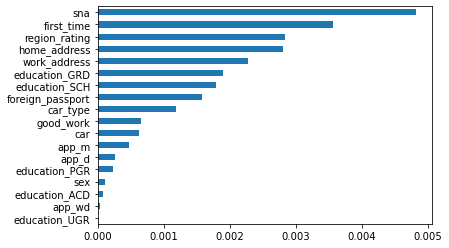

In [1388]:
# оценим значимость влияния бинарных и категорильных признаков на целевой признак
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'], discrete_features=True),
                    index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [1389]:
# признаки даты заявки (месяц, день, день недели), пол заемщика и виды образования PRG, ACD, UGR мало связаны с целевым признаком
# кроме того, отметим, что влияние признака car менее значимое, чем признак car_type, а так как суть признаков однотипна, то есть смысл оставить
# только наиболее значимый из них car_type
# удалим наименее значимые из категориальных и бинарных признаки
cat_to_del = ['car', 'app_m', 'app_d', 'app_wd', 'sex',
              'education_PGR', 'education_ACD', 'education_UGR']
data.drop(cat_to_del, axis=1, inplace=True)

In [1390]:
# из списков видов признаков удалим признаки:
for col in ['app_m', 'app_d', 'app_wd']:
    cat_cols.remove(col)
for col in ['car', 'sex', 'education_PGR', 'education_ACD', 'education_UGR']:
    bin_cols.remove(col)

In [1391]:
display(data)

,age,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,test_df,default,education_GRD,education_SCH
0,29,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,1,0,1,0
1,39,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,1,0,0,1
2,50,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,1,0,0,0
3,56,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,1,0,0,1
4,38,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,45,0,0,0,-1.792064,3,50,1,2,17000,4,4,0,0,0,1,0
110144,41,1,0,0,-2.058029,1,50,2,2,70000,1,4,0,0,0,0,1
110145,31,0,0,0,-1.512635,4,80,2,3,45000,2,2,0,0,0,0,1
110146,29,0,0,1,-1.479334,3,50,1,3,13000,2,3,0,0,1,0,1


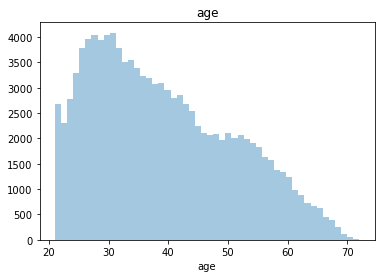

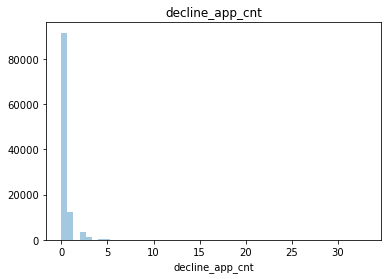

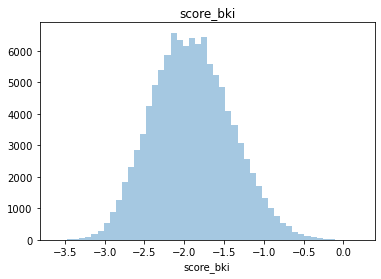

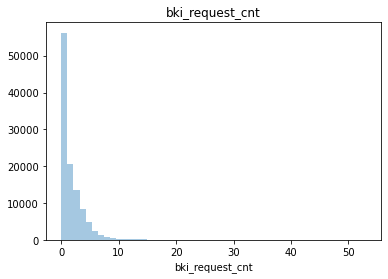

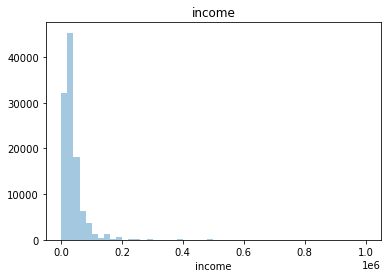

In [1392]:
# рассмотрим теперь количественные признаки
for col in num_cols:
    plt.figure()
    sns.distplot(data[col], kde=False, rug=False)
    plt.title(col)
    plt.show()

In [1393]:
# судя по полученным графикам, распределения всех количественных признаков, кроме score_bki, имеют смещения, и, скорее всего, выбросы.
# проверим это
def num_information(col):
    print(f'Признак {col} имеет следующее распределение:')
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    IQR = perc75 - perc25
    print(
        f'Границы диапазона признака: [{data[col].min()}; {data[col].max()}]')
    print(
        f'Границы выбросов: [{perc25 - 1.5 * IQR:.3f}; {perc75 + 1.5 * IQR:.3f}]')
    if (perc25 - 1.5 * IQR > data[col].min()) or (perc75 + 1.5 * IQR < data[col].max()):
        perc_emissions = ((data[data[col] < (perc25 - 1.5 * IQR)].shape[0]) +
                          data[data[col] > (perc75 + 1.5 * IQR)].shape[0]) / data[col].shape[0] * 100
        print(
            f'Выбросы есть и составляют {perc_emissions:.3f}% от всех значений\n')
    else:
        print('Выбросов нет!\n')
    return


for col in num_cols:
    num_information(col)

Признак age имеет следующее распределение:
Границы диапазона признака: [21; 72]
Границы выбросов: [3.000; 75.000]
Выбросов нет!

Признак decline_app_cnt имеет следующее распределение:
Границы диапазона признака: [0; 33]
Границы выбросов: [0.000; 0.000]
Выбросы есть и составляют 16.956% от всех значений

Признак score_bki имеет следующее распределение:
Границы диапазона признака: [-3.62458632; 0.19977285]
Границы выбросов: [-3.299; -0.529]
Выбросы есть и составляют 0.470% от всех значений

Признак bki_request_cnt имеет следующее распределение:
Границы диапазона признака: [0; 53]
Границы выбросов: [-4.500; 7.500]
Выбросы есть и составляют 2.393% от всех значений

Признак income имеет следующее распределение:
Границы диапазона признака: [1000; 1000000]
Границы выбросов: [-22000.000; 90000.000]
Выбросы есть и составляют 6.355% от всех значений



In [1394]:
# логарифмируем признак age
data['age'] = np.log(data['age'] + 1)

# логарифмируем признак decline_app_cnt
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)

# логарифмируем признак income
data['income'] = np.log(data['income'] + 1)

# логарифмируем признак bki_request_cnt
data['bki_request_cnt'] = np.log(data.bki_request_cnt + 1)

In [1395]:
# Нормализация численных данных
from sklearn.preprocessing import StandardScaler

for column in num_cols:
    data[column] = StandardScaler().fit_transform(
        np.array(data[column].values).reshape(-1, 1))

## FEATURE ENGINEERING

In [1396]:
# введём признак: средний доход по уровню региона
income_mean_reg = data.groupby('region_rating')['income'].mean().to_dict()
data['income_mean_region'] = data['region_rating'].map(income_mean_reg)

In [1397]:
# введём признак: средний доход по домашнему адресу
income_mean_ha = data.groupby('home_address')['income'].mean().to_dict()
data['income_mean_home_address'] = data['home_address'].map(income_mean_ha)

In [1398]:
# введём признак: средний доход по рабочему адресу
income_mean_wa = data.groupby('work_address')['income'].mean().to_dict()
data['income_mean_work_address'] = data['work_address'].map(income_mean_wa)

In [1399]:
# введём признак: относительную величину дохода в регионе: income / income_mean_region
data['income_reg_comparative'] = data['income'] / data['income_mean_region']

In [1400]:
# введём признак: относительную величину дохода по домашнему адресу: income / income_mean_home_address
data['income_ha_comparative'] = data['income'] / \
    data['income_mean_home_address']

In [1401]:
# введём признак: относительную величину дохода по рабочему адресу: income / income_mean_work_address
data['income_wa_comparative'] = data['income'] / \
    data['income_mean_work_address']

In [1402]:
# стандартизируем количественные признаки с помощью StandardScaler()
num_cols += ['income_mean_region', 'income_mean_home_address', 'income_mean_work_address',
             'income_reg_comparative', 'income_ha_comparative', 'income_wa_comparative']
data[num_cols] = StandardScaler().fit_transform(data[num_cols])

<AxesSubplot:>

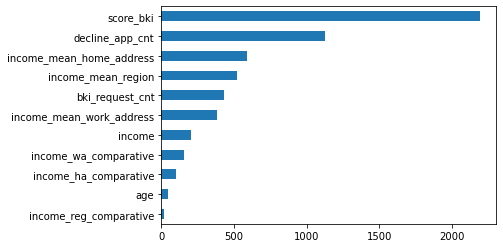

In [1403]:
# рассмотрим влияние количественных признаков на целевой признак
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[
                    0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

<AxesSubplot:>

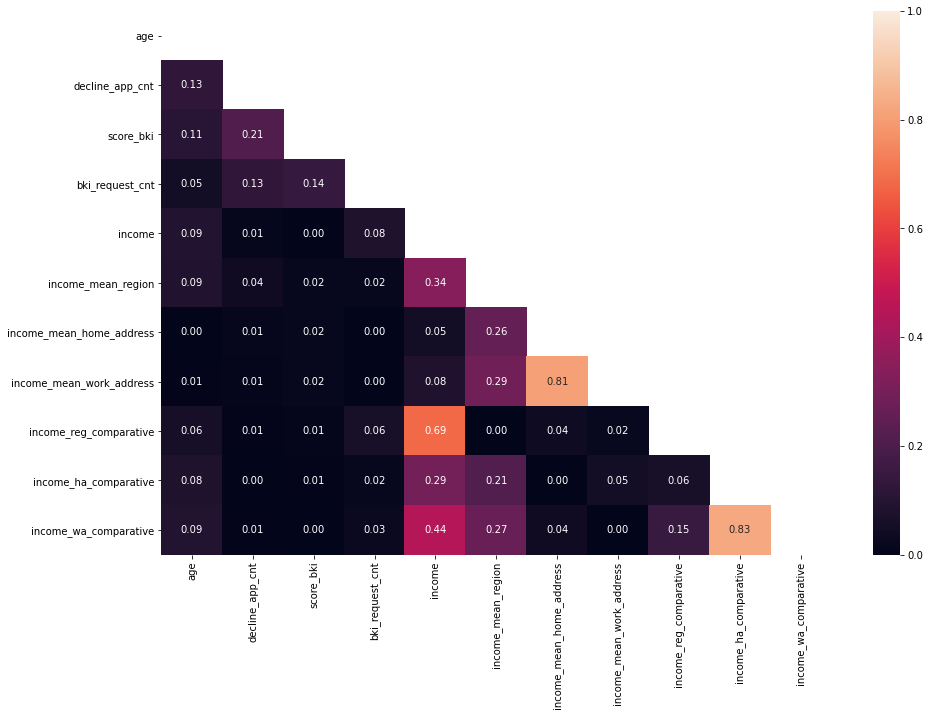

In [1404]:
# корреляция количественных признаков между собой:
matrix = np.triu(data[num_cols].corr())
plt.figure(figsize=(15, 10))
sns.heatmap(data[num_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt='.2f', mask=matrix)

In [1405]:
# создадим функцию, показывающую наиболее скоррелированные пары признаков
# на входе имеем data_frame - исходный датафрейм, col_featuries - количество наиболее скоррелированных пар признаков для показа (по умолчанию - 5)
def corr_data(data_frame, col_featuries=5):
    corr = data_frame.corr()
    triangle = np.abs(corr).where(
        np.tril(np.ones(corr.shape), k=-1).astype(bool))
    triangle = triangle.stack().sort_values(ascending=False)
    print('Наиболее скоррелированными являются следующие признаки:',
          triangle[:col_featuries], sep='\n')
    return


corr_data(data, 7)

Наиболее скоррелированными являются следующие признаки:
income_mean_home_address  home_address                0.974043
income_mean_region        region_rating               0.931546
income_mean_work_address  work_address                0.834009
income_wa_comparative     income_ha_comparative       0.825300
income_mean_work_address  income_mean_home_address    0.806859
                          home_address                0.779800
income_mean_home_address  work_address                0.751555
dtype: float64


In [1406]:
# судя по значениям корреляции новые признаки относительной величины дохода оказались сильно скореллированы с признаком income
# кроме того признак income_mean_work_address и income_mean_home_address обладают довольно значимой корреляцией 0,8
# наименьшее влияние из категориальных признаков на целевой оказывают income_wa_comparative, income_ha_comparative, income, age, income_reg_comparative
# удалим эти признаки, а также признак income_mean_work_address, как наименее важный из двух скоррелированных
num_cols_del = ['income_wa_comparative', 'income_ha_comparative',
                'income', 'age', 'income_reg_comparative', 'income_mean_work_address']
data.drop(num_cols_del, axis=1, inplace=True)
for col in num_cols_del:
    num_cols.remove(col)

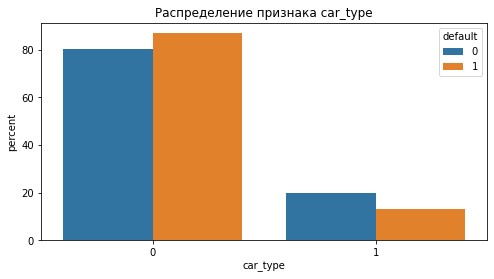

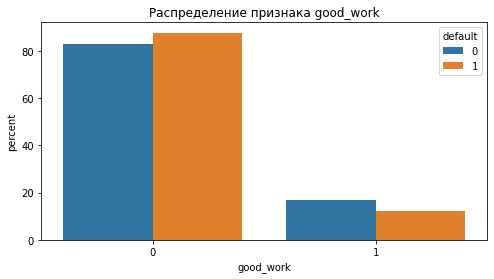

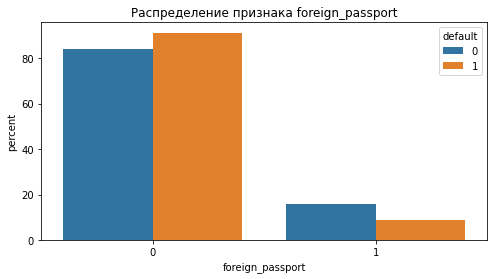

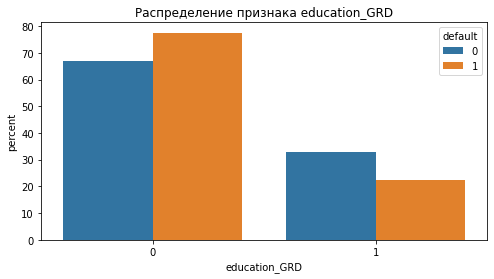

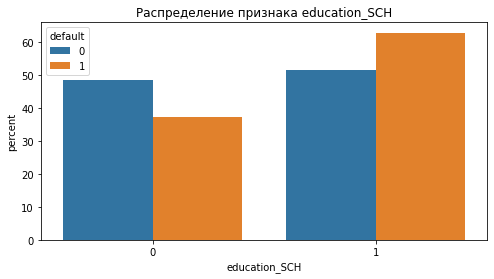

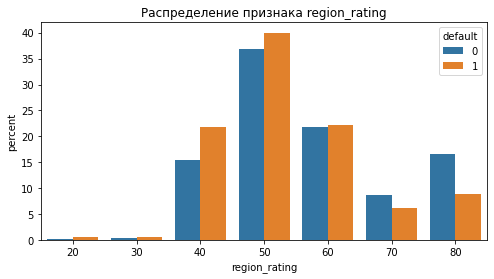

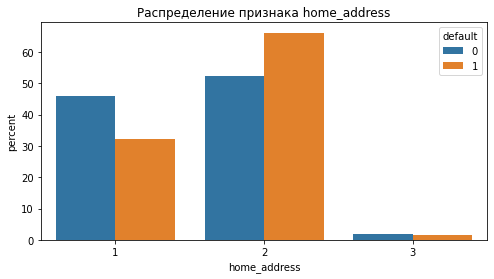

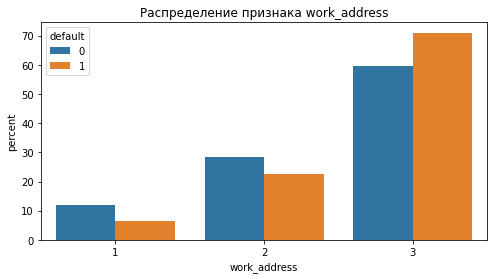

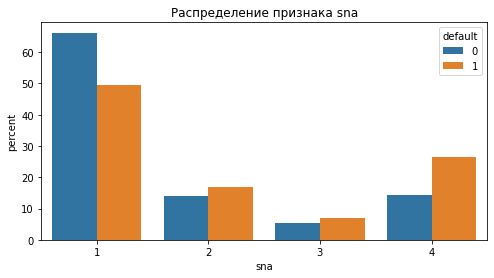

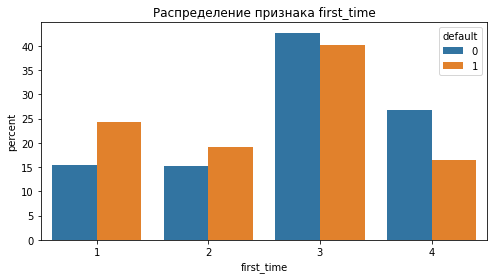

In [1407]:
# рассмотрим распределение оставшихся категориальных и бинарных признаков по целевомы признаку в процентах
data1 = data[data["test_df"] == 0]
for col in bin_cols + cat_cols:
    plt.figure(figsize=(8, 4))
    prop_df = data1[col].groupby(data1["default"]).value_counts(
        normalize=True).rename("percent").reset_index()
    prop_df["percent"] *= 100
    sns.barplot(x=col, y="percent", hue="default", data=prop_df)
    plt.title(f"Распределение признака {col}")

# Выводы по исследуемым категориальным и бинарным признакам:

car_type - клиентов с иномаркой около 20%, в целом клиенты с иномаркой допускают чуть меньше дефолтов;

good_work - хорошую работу имеет менее 20% обратившихся за кредитом, и такие люди чуть меньше допускают дефолты;

foreing_passport - иностранный паспорт также у менее, чем 20% обратившихся, и в целом граждане с таким паспортом менее дефолтные;

education_GRD - этот вид образования имеет порядка 20-30% обратившихся за кредитом, наличие этого образования свидетельствует о чуть меньшей дефолтности;

education_SCH - этот вид образования имеет порядка 50-60% обратившихся за кредитом, и довольно значительная их часть имеет тенденцию к невозврату;

regional_rating - средит всех обратившихся за кредитом регионы с рейтингом 50 составляют 35-40%, с рейтингами 40, 60 - 15%-20%, при этом такие регионы являются наиболее дефолтными;

home_address - наиболее задействованы виды адресов 1 и 2, причем до 60% дефолтов приходится на home_address=2;

work_address - наиболее представлены обращения с адресов 3 и 2, и наиболе дефолтным является 3 (до 70%);

sna - наиболее дефолтны заемщики с видами связи с клиентами банка 1 и 4;

first_time - наиболее дефолтные заёмщики с видом связи 3 и 1

In [1408]:
# с помощью метода .get_dummies преобразуем оставшиеся категориальные признаки
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

In [1409]:
display(data)

,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,foreign_passport,test_df,default,education_GRD,education_SCH,income_mean_region,income_mean_home_address,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,1,-0.418815,0,-0.735587,0.770563,0,1,0,1,0,-0.587943,-1.123364,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1
1,0,4.539989,0,0.800039,0.333797,0,1,0,0,1,-0.587943,-1.123364,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0
2,1,-0.418815,0,0.426908,-0.281790,1,1,0,0,0,-0.587943,-1.123364,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0
3,0,-0.418815,0,-0.940432,-0.281790,0,1,0,0,1,-0.801289,-1.123364,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0
4,0,-0.418815,0,-1.167347,-1.334144,0,1,0,1,0,1.872131,0.885829,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0,-0.418815,0,0.225214,0.770563,0,0,0,1,0,-0.587943,-1.123364,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1
110144,1,-0.418815,0,-0.307360,-0.281790,0,0,0,0,1,-0.587943,0.885829,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1
110145,0,-0.418815,0,0.784750,1.109345,0,0,0,0,1,1.872131,0.885829,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0
110146,0,-0.418815,1,0.851432,0.770563,0,0,1,0,1,-0.587943,-1.123364,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0


## СТРОИМ МОДЕЛЬ

In [1410]:
train_df = data[data['test_df'] == 0].drop(['test_df'], axis=1)
test_df = data[data['test_df'] == 1].drop(['test_df'], axis=1)
X = train_df.drop(['default'], axis=1)
y = train_df['default']
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, random_state=42)
model = LogisticRegression(class_weight='balanced',
                           solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

In [1411]:
from sklearn.metrics import classification_report
classification_report = classification_report(y_valid, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.94      0.66      0.78     12933
           1       0.22      0.69      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.72     14760



## КРИВАЯ ROC-AUC

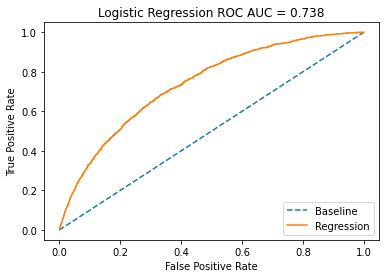

In [1412]:
# построим график кривой ROC AUC
probs = model.predict_proba(X_valid)[:, 1]

fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [1413]:
# создадим функцию печати всех необходимых для анализа метрик
# на входе у нее датасеты y_true - исходные значения целевого показателя, y_pred - предсказанные значения целевого показателя,
# y_pred_proba - предсказанные значения для оценки параметра ROC-AUC
# на выходе - значения метрик для входных параметров
def print_regression_metrics(y_true, y_pred, y_pred_proba):
    acc = accuracy_score(y_true, y_pred)
    pres = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    ROC_AUC = roc_auc_score(y_true, y_pred_proba)

    print(f'accuracy_score={acc:.3f}, precision_score={pres:.3f}, recall_score={rec:.3f}, f1_score={f1:.3f},\nMSE = {mse:.3f}, RMSE = {rmse:.3f}, ROC-AUC={ROC_AUC:.3f}')
    return

In [1414]:
# тестовое обучение модели на исходных данных
clf = LogisticRegression(class_weight='balanced', solver='liblinear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
y_pred_proba = clf.predict_proba(X_valid)[:, 1]
print_regression_metrics(y_valid, y_pred, y_pred_proba)

accuracy_score=0.666, precision_score=0.224, recall_score=0.687, f1_score=0.338,
MSE = 0.334, RMSE = 0.578, ROC-AUC=0.738


## CONFUSION MATRIX

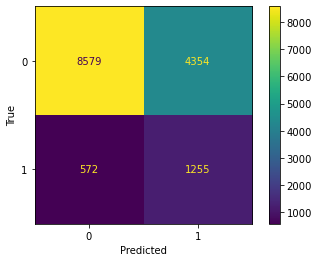

In [1415]:
# напишем функцию conf_matr
# на входе у нее реальные и предсказанные значения целевого признака
# на выходе - графическое отображение confusion matrix
def conf_matr(y_valid, y_pred):
    cm = confusion_matrix(y_valid, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
    cmd.plot()
    cmd.ax_.set(xlabel='Predicted', ylabel='True')
    return


conf_matr(y_valid, y_pred)

## ПОДБОР ГИПЕРПАРАМЕТРОВ

In [1416]:
# составим функцию selection_of_parameters подбора параметров с помощью GridSearchCV
# на вход функция получает датасеты с данными X, целевыми значениями y, начальным значением параметра С - p0 (по умолчнию равно p0=0),
# конечным значением параметра С - p1 (по умолчанию p1=10), количество интервалов разбиения между p0 и p1 - p_step (по умолчанию p_step=100)
def selection_of_parameters(X, y, p0=0, p1=10, p_step=100):
    penalty = ['l1', 'l2']
    C = np.logspace(p0, p1, p_step)
    hyperparameters = dict(C=C, penalty=penalty)

    model = LogisticRegression(class_weight='balanced')
    model.fit(X, y)

    clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
    best_model = clf.fit(X, y)

    print('Лучшее Penalty:',
          best_model.best_estimator_.get_params()['penalty'])
    print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
    return

In [1447]:
# подберем гиперпараметры
selection_of_parameters(X_train, y_train, 0, 4, 100)

Лучшее Penalty: l2
Лучшее C: 2.782559402207125


In [1448]:
# напишем функцию solver, принимающую на входе датасет df, параметр par(значение параметра penalty), по умолчанию par='l2',
# параметр const (значение параметра C), по умолчанию const=1
# на выходе функция выдаёт на печать метрики модели и confusion matrix
def solver(df, par='l2', const=1):
    y = df['default']
    X = df.drop(['default'], axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.20, random_state=42, shuffle=True)
    clf = LogisticRegression(
        par, C=const, max_iter=1000, class_weight='balanced')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]
    print_regression_metrics(y_valid, y_pred, y_pred_proba)
    conf_matr(y_valid, y_pred)
    return

accuracy_score=0.666, precision_score=0.224, recall_score=0.687, f1_score=0.338,
MSE = 0.334, RMSE = 0.578, ROC-AUC=0.738


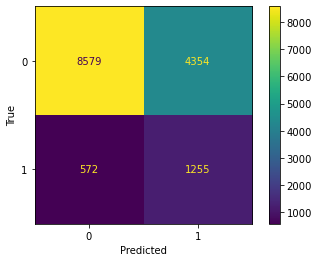

In [1449]:
# проверим метрики при полученных параметрах
solver(train_df, 'l2', 1.321941148466029)

## SUBMISSION

In [1450]:
# разбиваем исходный датасет на тренинговый и тестовый
train_data = data[data['test_df'] == 0].drop(['test_df'], axis=1)
test_data = data[data['test_df'] == 1].drop(['test_df'], axis=1)

# в тренинговом датасете выделяем X_train, y_train
X_train = train_data.drop(['default'], axis=1)
y_train = train_data['default']
# в тестовом датасете выделяем X_test
X_test = test_data.drop(['default'], axis=1)

# рассмотрим размеры полученных итоговых датасетов
print(
    f'Размеры датасетов: \ntrain_data:{train_data.shape},\ntest_data:{test_data.shape},\nX_train:{X_train.shape},\ny_train:{y_train.shape},\nX_test:{X_test.shape}')

Размеры датасетов: 
train_data:(73799, 32),
test_data:(36349, 32),
X_train:(73799, 31),
y_train:(73799,),
X_test:(36349, 31)


In [1451]:
# обучаем модель с учетом подобранных гиперпараметров
best_model = LogisticRegression(
    class_weight='balanced', random_state=42, penalty='l2', C=1.321941148466029, max_iter=1000)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [1452]:
# создаем итоговый файл submission.csv
submit = pd.DataFrame(test.client_id)
submit['default'] = y_pred_proba
submit.to_csv('submission.csv', index=False)
display(submit.head())

,client_id,default
0,74835,0.192405
1,17527,0.797730
2,75683,0.311332
3,26883,0.351155
4,28862,0.143874


Данные несбалансированные, метрика "accuracy" не подходит к нашей задаче. Нужно основываться на метриках "f1" и "roc_auc"  

In [1453]:
import shap

In [1454]:
explainer = shap.LinearExplainer(
    best_model, X_train, feature_dependence="independent")
shap_values = explainer(X_test)

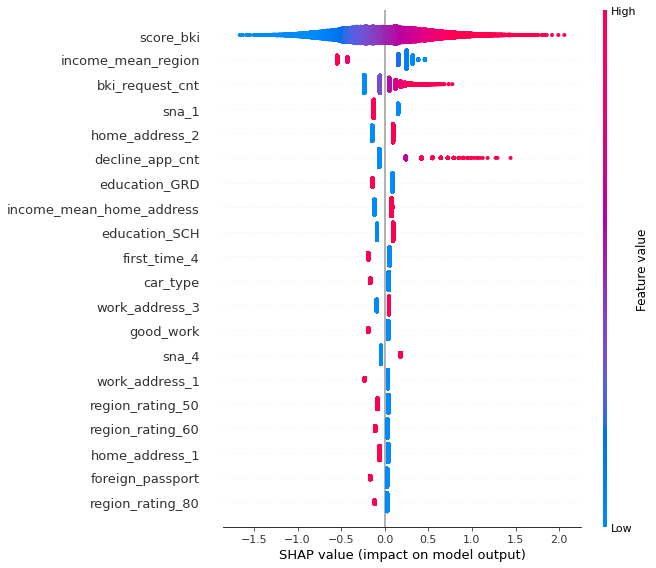

In [1455]:
# summary plot
shap.summary_plot(shap_values, X_test)

Признаки расположены по степени их важности по оси OY, по оси OX находится значение Шепли. Каждая точка является отдельно взятым наблюдением.  
Цветом обозначены значения соответствующего признака: красный - высокие, синий - низкие.  
чем больше значение признака score_bki, тем больше вероятность дефолта.
